# Create Strips of Stop and Stare Data for Reconstruction
This notebook takes a list of existing datasets and performs registration and reconstruction of each stop-and-stare dataset in the stack

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob

# Debugging imports
import llops as yp
import ndoperators as ops
import matplotlib.pyplot as plt

yp.config.setDefaultBackend('numpy')

ModuleNotFoundError: No module named 'ndoperators'

## Load Data

In [5]:
# Define user for path setting
dataset_path = '/Users/zfphil/datasets/motiondeblur/'
# dataset_path = '/Volumes/Datasets/einstein_data'

# Find files in this directory
folder_list = glob.glob(os.path.join(dataset_path, '*/'))
dataset_list = [folder for folder in folder_list if isDataset(folder)]

# Select only the stop and stare datasets
sns_dataset_list = [folder_name for folder_name in folder_list if 'stopandstare' in folder_name]

# Select res target (for debugging)
sns_dataset_list = [s for s in sns_dataset_list if 'res' in s]

# Select dataset (for now)
dataset_index = 0

# Create dataset object (loads metadata)
dataset = Dataset(sns_dataset_list[dataset_index])

# Force type to be motiondeblur
dataset.metadata.type = 'motiondeblur'

# Select green channel
dataset.channel_mask = [0]

# Preprocess dataset (md-specific)
md.preprocess(dataset)

# Get linear segment count
linear_segment_count = len(dataset.position_segment_indicies)

# Single-Segment Recovery

<IPython.core.display.Javascript object>


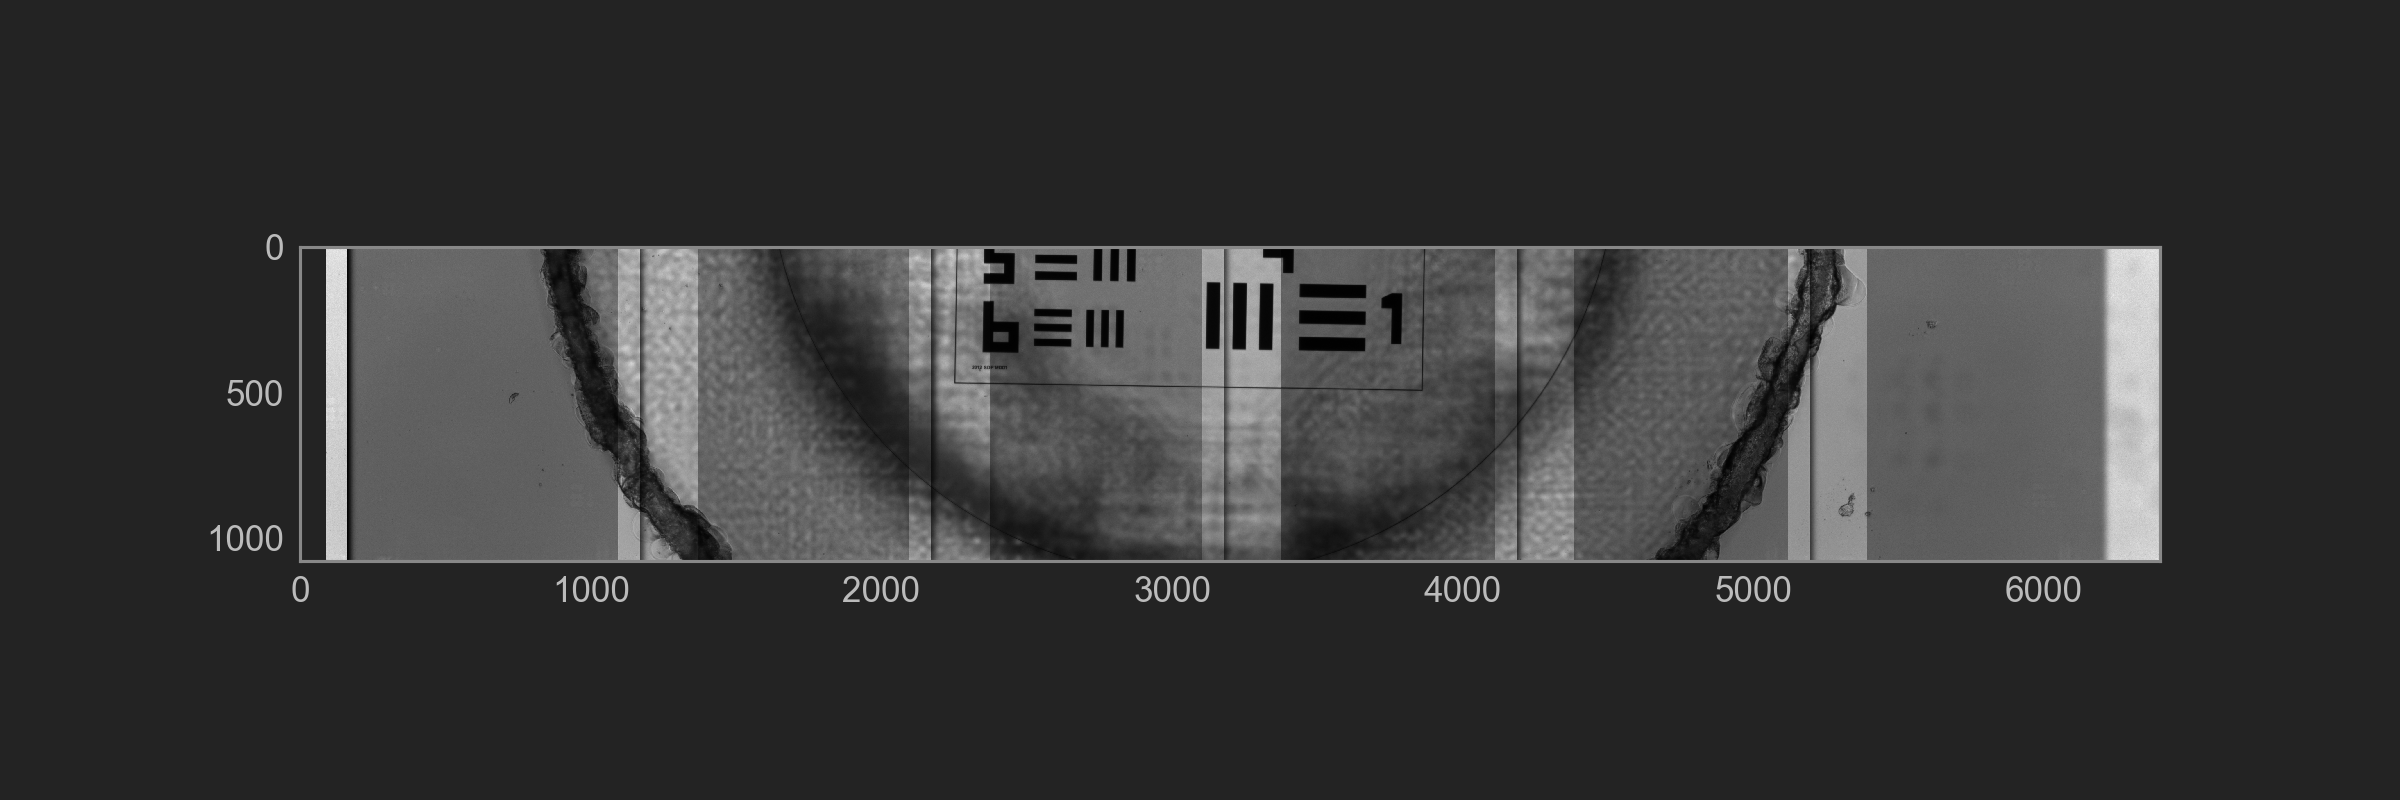

In [6]:
# Define segment
position_segment_index = 4
dataset.position_segment_indicies = [position_segment_index]
    
# Create recon object
recon = md.Reconstruct(dataset, alpha_blend_distance=50)

# Normalize measurements
recon.normalize_measurements()

# Register measurements
offsets = recon.register_measurements(registration_energy_ratio_threshold=1.03, axis=1, debug=False, force_2d=True)

# # Reconstruct by direct inversion
recon.reconstruct(iteration_count=-1, reg_types={'l2': 1e-4}, step_size=1e-4) 

# # Show figure
plt.figure()
plt.imshow(yp.real(recon.object_recovered))

In [148]:
offsets = recon.register_measurements(registration_energy_ratio_threshold=1.03, axis=1, force_2d=True,
                                      debug=False, write_results=False)

In [38]:
recon.normalize_measurements(debug=True, write_results=False)

0.9823593641948324
0.98235935
L2 difference: 0.437885


<IPython.core.display.Javascript object>


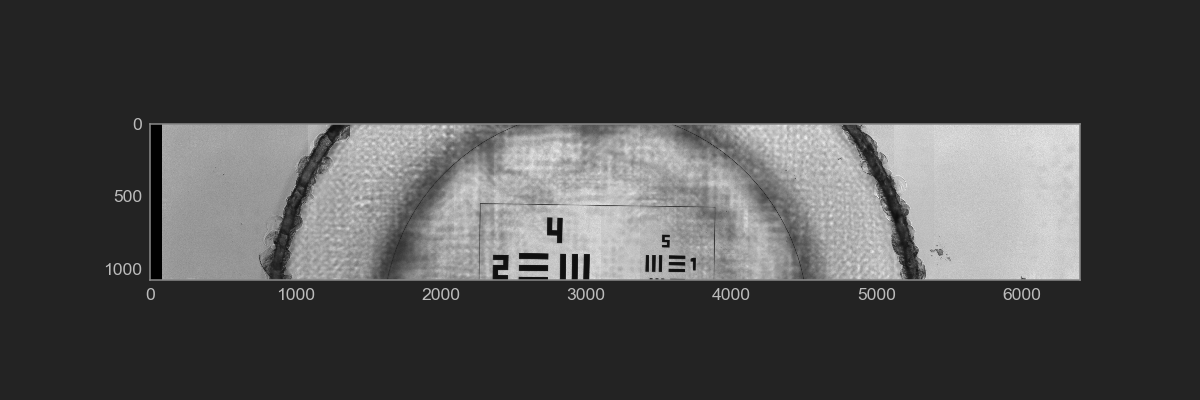

In [32]:
# Reconstruct by direct inversion
recon.reconstruct(iteration_count=-1, reg_types={'l2': 1e-4}, step_size=1e-4) 

# Show figure
plt.figure()
plt.imshow(yp.real(recon.object_recovered))

# Process Segments and Save as Reconstructions in Dataset

In [150]:
for position_segment_index in yp.display.progressBar(range(linear_segment_count), name='Position Segments Processed'):
    # Update position_segment_index in dataset
    dataset.position_segment_indicies = [position_segment_index]

    # Create recon object
    recon = md.Reconstruct(dataset, alpha_blend_distance=50)

    # Normalize measurements
    recon.normalize_measurements()

    # Register measurements
    offsets = recon.register_measurements(registration_energy_ratio_threshold=1.03, axis=1, debug=False, force_2d=True)

    # # Reconstruct by direct inversion
    recon.reconstruct(iteration_count=-1, reg_types={'l2': 1e-4}, step_size=1e-4) 
    
    # Store results
    dataset.saveReconstruction(recon.object_recovered, recon.reconstruction_parameters, 
                               label='segment_%03d' % position_segment_index, omit_time_in_filename=True)

Saved reconstruction to file header: /Users/zfphil/datasets/motiondeblur/res_target_color_stopandstare_raster_multi_contrast_2018_05_22_19_16_26/reconstructions/reconstruction_segment_000
Saved reconstruction to file header: /Users/zfphil/datasets/motiondeblur/res_target_color_stopandstare_raster_multi_contrast_2018_05_22_19_16_26/reconstructions/reconstruction_segment_001
Saved reconstruction to file header: /Users/zfphil/datasets/motiondeblur/res_target_color_stopandstare_raster_multi_contrast_2018_05_22_19_16_26/reconstructions/reconstruction_segment_002
Saved reconstruction to file header: /Users/zfphil/datasets/motiondeblur/res_target_color_stopandstare_raster_multi_contrast_2018_05_22_19_16_26/reconstructions/reconstruction_segment_003
Saved reconstruction to file header: /Users/zfphil/datasets/motiondeblur/res_target_color_stopandstare_raster_multi_contrast_2018_05_22_19_16_26/reconstructions/reconstruction_segment_004
Saved reconstruction to file header: /Users/zfphil/datasets/

## Scaling Up - Process all Dataset Strips

In [ ]:
for dataset_single_path in yp.display.progressBar(sns_dataset_list[1:]):
    # Create dataset object (loads metadata)
    dataset = Dataset(dataset_single_path)

    # Force type to be motiondeblur
    dataset.metadata.type = 'motiondeblur'

    # Select green channel
    dataset.channel_mask = [0]

    # Preprocess dataset (md-specific)
    md.preprocess(dataset)

    # Get linear segment count
    linear_segment_count = len(dataset.position_segment_indicies)

    for position_segment_index in yp.display.progressBar(range(linear_segment_count), name='Position Segments Processed'):
        # Update position_segment_index in dataset
        dataset.position_segment_indicies = [position_segment_index]

        # Create recon object
        recon = md.Reconstruct(dataset, alpha_blend_distance=0)

        # Register frames
        offsets = recon.register_measurements(registration_energy_ratio_threshold=1.2)

        # Normalize frame intensity
        recon.normalize_measurements()

        # Reconstruct by direct inversion
        recon.reconstruct(iteration_count=-1, reg_types={'l2': 1e-4}, step_size=1e-4)

        # Store results
        dataset.saveReconstruction(recon.object_recovered, recon.reconstruction_parameters, 
                                   label='segment_%03d' % position_segment_index, omit_time_in_filename=True)

## Stitch Reconstructions Back Together

In [162]:
offsets = recon_full.register_segments(write_results=True)

In [161]:
offsets

[array([-0.,  0.]),
 array([-13.,   0.]),
 array([-27.,   0.]),
 array([-44., -55.]),
 array([-61., -55.]),
 array([-78., -55.]),
 array([-96., -55.])]

Stitching segments...
Stitched 7 segments sucessfully!


<IPython.core.display.Javascript object>


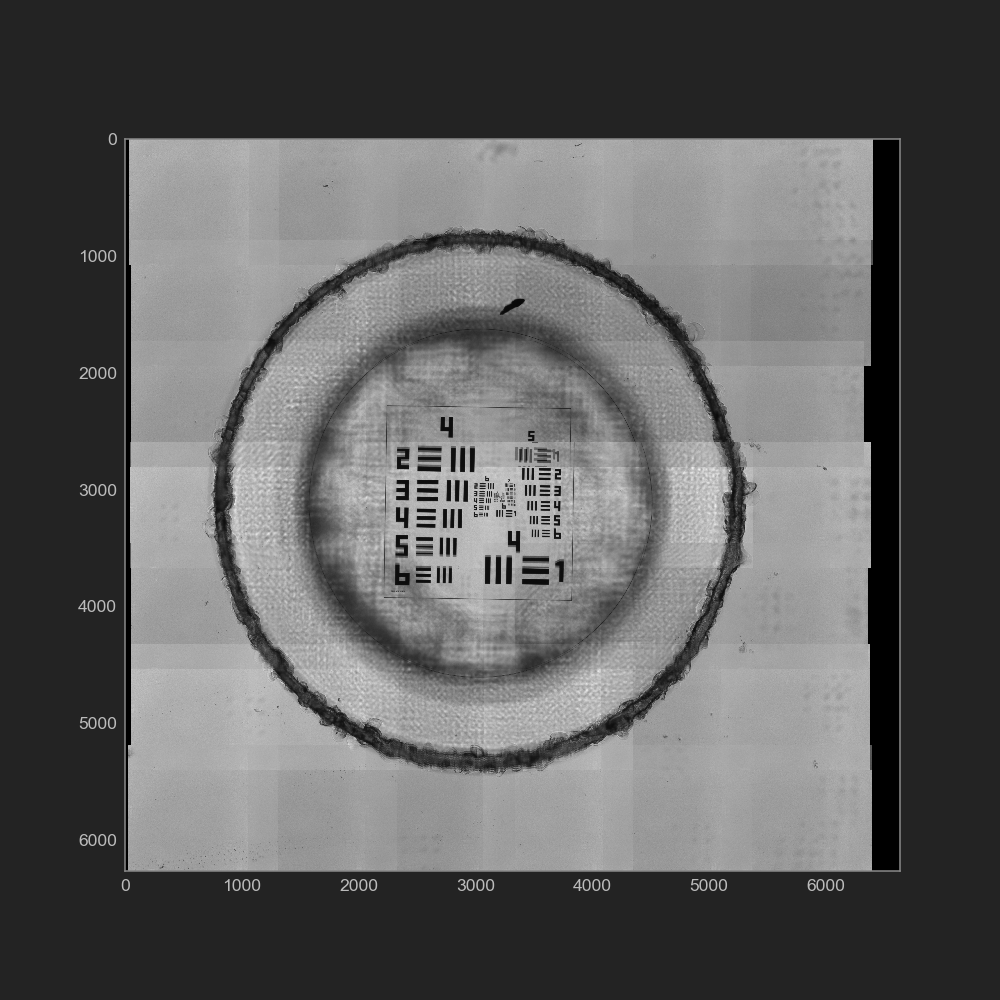

In [151]:
# Create a 'full' reconstruction object, which processes strips and segments
recon_full = md.recon.FullReconstruction(dataset)

# Perform reconstruction
recon_full.reconstruct(iteration_count=-1)

# Show result
recon_full.show()

<IPython.core.display.Javascript object>


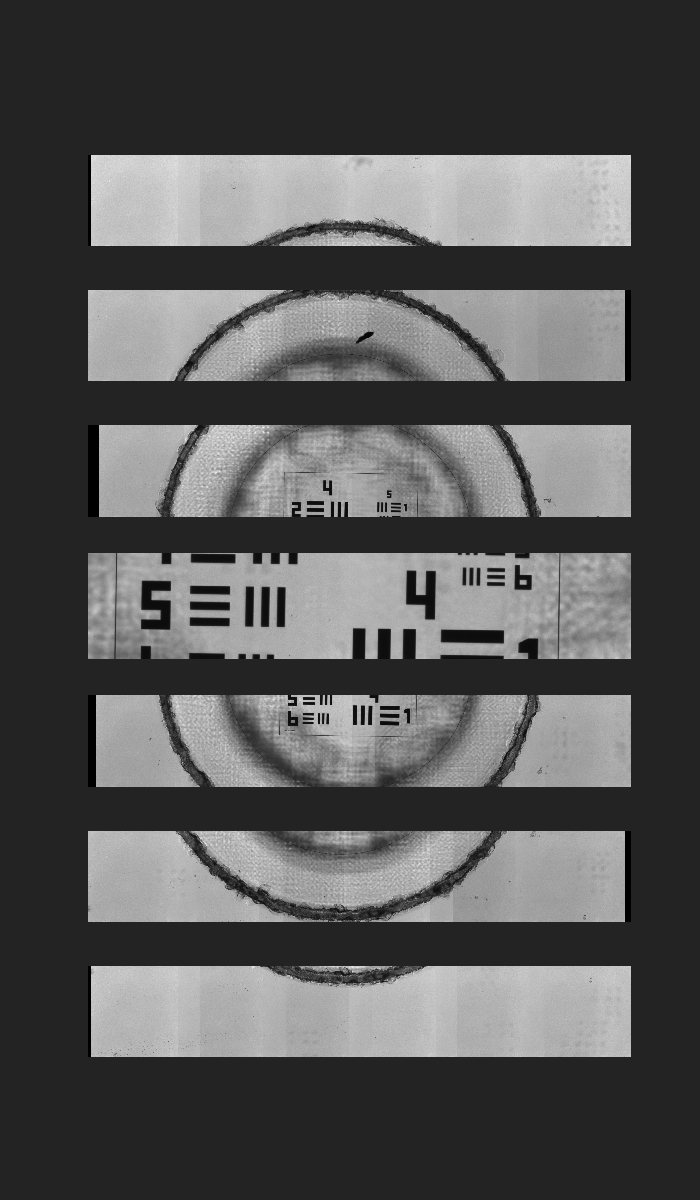

In [156]:
yp.display.listPlotFlat(recon_full.reconstructed_segments, max_width=1, figsize=(7,12))

<IPython.core.display.Javascript object>


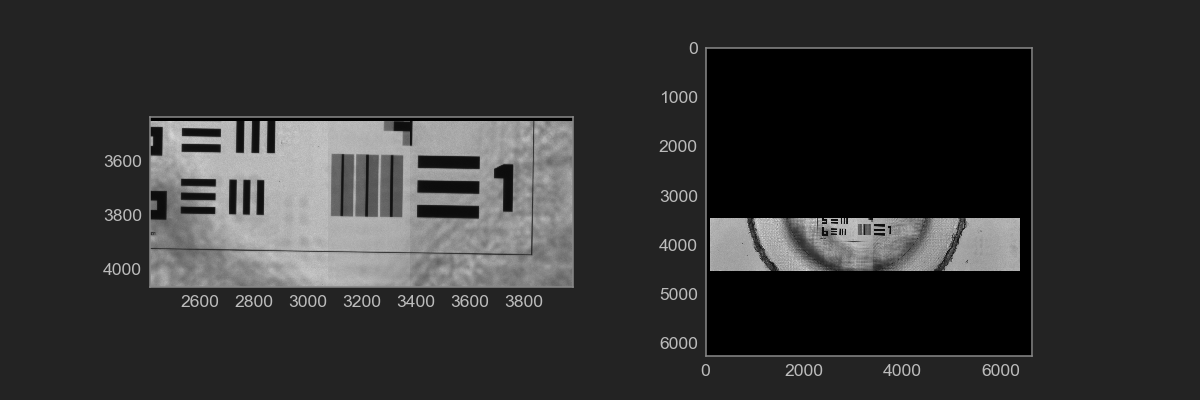

In [108]:
y_list = recon_full.reconstructed_segments[4:5]
roi_list = recon_full.segment_roi_list[4:5]
G = ops.Segmentation(roi_list, roi_list[0].input_shape)
y = ops.VecStack(y_list)

plt.figure()
plt.subplot(121)
plt.imshow(yp.real(G.inv(y)))
plt.subplot(122)
plt.imshow(yp.real(G.inv(y)))

<IPython.core.display.Javascript object>


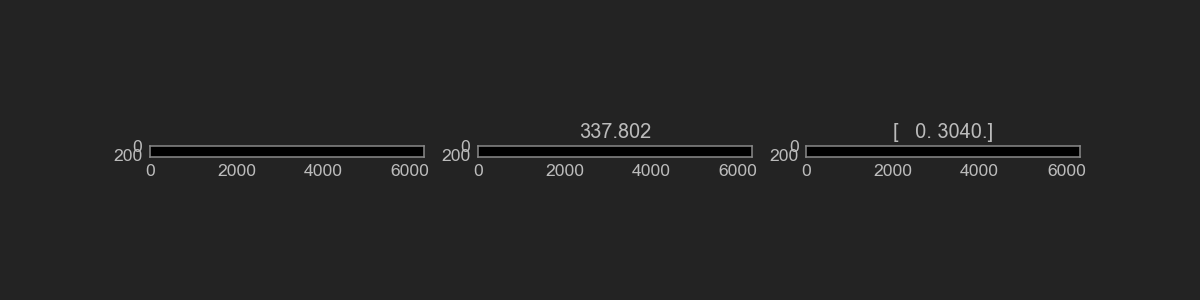

[array([0., 0.]), array([  0., 200.])]


In [79]:
offsets = md.recon.register_roi_list(y_list,roi_list, debug=True, axis=1)
print(offsets)